In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from matplotlib import patches

from utils.distributions import marchenko_pastur_svals

In [26]:
matplotlib.rcParams.update({'font.size': 20})
figsize = (8, 5)

In [27]:
def plot_svals(svals, m, n, sigma, layer, block, with_numbers: bool = False):

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    y_mp, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)
    y_mp = y_mp / torch.trapezoid(y_mp, x_mp)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    
    ax.hist(svals, color = "b", density=True, bins="fd")
    ax.plot(x_mp, y_mp, 
                color = "r", linestyle = "--", linewidth = 2, alpha = 0.7, label = "MP distribution")
    ax.set_xlim(0, x_mp[-1])
    ax.set_xlabel(r"$s$")
    ax.set_ylabel("Density")

    if with_numbers:
        ax.text(0.9, 0.1, "(1)", transform=ax.transAxes, fontweight="bold")
    
    ax.legend()

    fig.suptitle(f"{layer} - Block {block}")

    saving_dir = f"{plot_dir}/svals"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    plt.savefig(f"{saving_dir}/h.{block}.{layer}.pdf", bbox_inches="tight")
    return

In [28]:
def plot_overlaps(svals, overlaps, m, n, sigma, layer, block, with_numbers: bool = False):

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    y_mp, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)
    y_mp = y_mp / torch.trapezoid(y_mp, x_mp)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    fig, ax = plt.subplots(nrows=1, figsize=figsize)
    
    ax.plot(overlaps, color = "b")
    ax.vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, 
                  color = "r", alpha = 0.7, linestyle = "--", label = "MP bounds")
    ax.grid(alpha=0.5)
    ax.set_ylim(0,0.5)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$O_k$")

    if with_numbers:
        ax.text(0.9, 0.1, "(2)", transform=ax.transAxes, fontweight="bold")
    
    ax.legend()

    fig.suptitle(f"{layer} - Block {block}")

    saving_dir = f"{plot_dir}/overlaps"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    plt.savefig(f"{saving_dir}/h.{block}.{layer}.pdf", bbox_inches="tight")
    return

In [89]:
def plot_overlaps_comparison(overlaps_a, overlaps_b, label_a, label_b, svals, m, n, sigma, layer, block):

    fig, ax = plt.subplots(figsize=figsize)
    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    _, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    # plotting
    ax.plot(np.arange(overlaps_a.shape[0]), overlaps_a, label = label_a, alpha = 1)
    ax.plot(np.arange(overlaps_b.shape[0]), overlaps_b, label = label_b, alpha = 1)
    mp_bounds = ax.vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", alpha = 0.5, linestyle = "--", label = "MP bounds")
    ax.grid(alpha = 0.7)
    ax.set_ylim(0,0.5)
    
    # pathces
    rectangle = patches.Rectangle((0.02, 0.15), 0.3, 0.4, fill=False, edgecolor='red', linewidth=2, transform=ax.transAxes, zorder=10)
    ax.add_patch(rectangle)

    ax.set_xlabel("Right singular vector index")
    ax.set_ylabel("Overlap")

    ax.set_title(f"{layer} - Block {block}")
    
    ax.legend()

    saving_dir = f"{plot_dir}/overlaps_comparison"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    fig.tight_layout()
    plt.savefig(f"{saving_dir}/h.{block}.{layer}.pdf", bbox_inches="tight")
    
    return

In [94]:
def plot_overlap_comparison(layer: str, block: int, m: int, n: int, plot_dir: str, patch: bool = False, patch_coords: list = None):

    overlap_a = pd.read_csv(f"random/data/overlaps/{layer}.csv").iloc[:,block + 1]
    overlap_b = pd.read_csv(f"eco/data/overlaps/{layer}.csv").iloc[:,block + 1]
    svals = pd.read_csv(f"eco/data/svals/{layer}.csv").iloc[:,block + 1]
    sigma = svals.iloc[0]
    svals = svals.iloc[1:].to_numpy()

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    _, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    fig, axs = plt.subplots(nrows=2, figsize = (figsize[0], figsize[1]*2))

    axs[0].plot(overlap_a, color = "blue", alpha = 0.9, label = "random")

    axs[0].vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", alpha = 0.7, linestyle = "--", label = "MP bounds")

    axs[0].grid(alpha = 0.5)

    axs[1].plot(overlap_b, color = "orange", alpha = 0.9, label = "eco")

    axs[1].vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", alpha = 0.7, linestyle = "--", label = "MP bounds")

    axs[1].grid(alpha = 0.5)

    if patch:
        rectangle = patches.Rectangle((patch_coords[0], patch_coords[1]), patch_coords[2], patch_coords[3], 
                                      fill=False, edgecolor='red', linewidth=2, transform=axs[0].transAxes, zorder=10)
        axs[0].add_patch(rectangle)
        rectangle = patches.Rectangle((patch_coords[0], patch_coords[1]), patch_coords[2], patch_coords[3], 
                                      fill=False, edgecolor='red', linewidth=2, transform=axs[1].transAxes, zorder=10)
        axs[1].add_patch(rectangle)
    
    axs[0].set_ylim(0,0.5)
    axs[1].set_ylim(0,0.5)
    
    
    axs[1].set_xlabel(r"$k$")
    axs[0].set_ylabel(r"$O_k$")
    axs[1].set_ylabel(r"$O_k$")
    
    axs[0].tick_params(labelbottom = False, bottom = False)
    
    axs[0].legend(ncol=1, loc="upper right")
    axs[1].legend(ncol=1, loc="upper right")
    
    fig.suptitle(f"{layer} - Block {block}")
    
    saving_dir = f"{plot_dir}/overlap_single_comparison/{layer}"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    plt.savefig(f"{saving_dir}/{block}.pdf", bbox_inches="tight")
    # plt.close(fig)

    return

In [31]:
def plot_overlap_bands(overlaps_a, svals, m, n, sigma, layer, block):

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    _, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    mean_overlap_a = np.mean(overlaps_a, axis = 1)
    std_overlap_a = np.std(overlaps_a, axis = 1)

    fig, ax = plt.subplots(figsize = figsize)

    ax.plot(mean_overlap_a, color = "blue")

    ax.fill_between(np.arange(mean_overlap_a.shape[0]), 
                     mean_overlap_a - std_overlap_a, 
                     mean_overlap_a + std_overlap_a, 
                     alpha=0.3, 
                     color='blue', 
                     label=r'$\pm 1 \sigma$')

    ax.vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", linestyle = "--", label = "MP bounds")

    
    ax.grid(alpha = 0.5)
    ax.set_ylim(0,0.5)
    
    ax.set_xlabel("Right singular vector index")
    ax.set_ylabel("Overlap")
    
    ax.legend()
    
    fig.suptitle(f"{layer} - Block {block}")
    
    saving_dir = f"{plot_dir}/overlaps_bands"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    # fig.tight_layout()
    plt.savefig(f"{saving_dir}/h.{block}.{layer}.pdf", bbox_inches="tight")

    return

In [86]:
def plot_overlap_comparison_bands(layer: str, block: int, m: int, n: int, data_dir: str, plot_dir: str, patch: bool = False, patch_coords: list = None, close_up: bool = False):

    overlaps_a = pd.read_csv(f"random/data/overlaps/{layer}.csv").iloc[:,block + 1]
    overlaps_b = pd.read_csv(f"eco/data/overlaps/{layer}.csv").iloc[:,block + 1]
    svals = pd.read_csv(f"random/data/svals/{layer}.csv").iloc[:,block + 1]
    sigma = svals.iloc[0]
    svals = svals.iloc[1:].to_numpy()

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    _, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    mean_overlap_a = np.mean(overlaps_a, axis = 1)
    std_overlap_a = np.std(overlaps_a, axis = 1)
    mean_overlap_b = np.mean(overlaps_b, axis = 1)
    std_overlap_b = np.std(overlaps_b, axis = 1)

    fig, ax = plt.subplots(figsize = figsize)

    ax.plot(mean_overlap_a, color = "blue", alpha = 0.9, label = r"$(\mu \pm 1\sigma)_{\text{random}}$")

    ax.plot(mean_overlap_b, color = "orange", alpha = 0.9, label = r"$(\mu \pm 1\sigma)_{\text{eco}}$")

    ax.vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", alpha = 0.7, linestyle = "--", label = "MP bounds")

    ax.fill_between(np.arange(mean_overlap_a.shape[0]), 
                     mean_overlap_a - std_overlap_a, 
                     mean_overlap_a + std_overlap_a, 
                     alpha=0.3, 
                     color='blue')

    ax.fill_between(np.arange(mean_overlap_b.shape[0]), 
                     mean_overlap_b - std_overlap_b, 
                     mean_overlap_b + std_overlap_b, 
                     alpha=0.3, 
                     color='orange')

    if patch and not close_up:
        rectangle = patches.Rectangle((patch_coords[0], patch_coords[1]), patch_coords[2], patch_coords[3], 
                                      fill=False, edgecolor='red', linewidth=2, transform=ax.transAxes, zorder=10)
        ax.add_patch(rectangle)
    
    ax.grid(alpha = 0.5)
    ax.set_ylim(0,0.5)
    
    if close_up:
        y_range = 0.5
        x_range = mean_overlap_a.shape[0]
        ax.set_xlim(x_range * patch_coords[0], x_range * (patch_coords[0] + patch_coords[2]))
        ax.set_ylim(y_range * patch_coords[1], y_range * (patch_coords[1] + patch_coords[3]))
    
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$O_k$")
    
    if not close_up:
        ax.legend(ncol=1)
    
    fig.suptitle(f"{layer} - Block {block}")
    
    saving_dir = f"{plot_dir}/overlaps_comparison/{layer}"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    if close_up:
        plt.savefig(f"{saving_dir}/{block}.close_up.pdf", bbox_inches="tight")
    else:
        plt.savefig(f"{saving_dir}/{block}.pdf", bbox_inches="tight")
    # plt.close(fig)

    return

In [33]:
def plot_svals_overlaps(svals, overlaps, m, n, sigma, layer, block, with_numbers: bool = False):

    # marchenko-pastur distribution
    x_mp = torch.linspace(np.min(svals), np.max(svals), 1000)
    # the first element is removed because if 0 it leads to division error
    if (x_mp[0] < 1e-6):
        x_mp = x_mp[1:]
    y_mp, s_lower, s_upper = marchenko_pastur_svals(x_mp, sigma, m, n)
    y_mp = y_mp / torch.trapezoid(y_mp, x_mp)

    idx_lower = np.argmin(np.fabs(svals - s_lower))
    idx_upper = np.argmin(np.fabs(svals - s_upper))

    fig, axs = plt.subplots(nrows=2, figsize=(figsize[0], figsize[1] * 2))
    
    axs[0].hist(svals, color = "b", density=True, bins="fd")
    axs[0].plot(x_mp, y_mp, 
                color = "r", linestyle = "--", linewidth = 2, alpha = 0.7, label = "MP distribution")
    axs[0].set_xlim(0, x_mp[-1])
    axs[0].set_xlabel(r"$s$")
    axs[0].set_ylabel("Density")

    if with_numbers:
        axs[0].text(0.9, 0.1, "(1)", transform=axs[0].transAxes, fontweight="bold")
    
    axs[0].legend()
    
    axs[1].plot(overlaps, color = "b")
    axs[1].vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, 
                  color = "r", alpha = 0.7, linestyle = "--", label = "MP bounds")
    axs[1].grid(alpha=0.5)
    axs[1].set_ylim(0,0.5)
    axs[1].set_xlabel(r"$k$")
    axs[1].set_ylabel(r"$O_k$")

    if with_numbers:
        axs[1].text(0.9, 0.1, "(2)", transform=axs[1].transAxes, fontweight="bold")
    
    axs[1].legend()

    fig.suptitle(f"{layer} - Block {block}")

    saving_dir = f"{plot_dir}/svals_overlap"
    if not os.path.isdir(saving_dir):
        os.makedirs(saving_dir) 

    plt.savefig(f"{saving_dir}/h.{block}.{layer}.pdf", bbox_inches="tight")
    return

In [78]:
plot_dir = "presentation/plots"

In [80]:
final_data_dir = "final/data"

In [81]:
eco_data_dir = "eco/data"
random_data_dir = "random/data"

In [82]:
layer = "attn.c_attn.v"
block = 10

In [83]:
overlaps_a = pd.read_csv(f"{random_data_dir}/overlaps/{layer}.csv")
overlaps_b = pd.read_csv(f"{eco_data_dir}/overlaps/{layer}.csv")

In [84]:
overlaps_a = overlaps_a.iloc[:,block + 1].to_numpy()
overlaps_b = overlaps_b.iloc[:,block + 1].to_numpy()

In [85]:
svals = pd.read_csv(f"{eco_data_dir}/svals/{layer}.csv")
svals = svals.iloc[:,block]

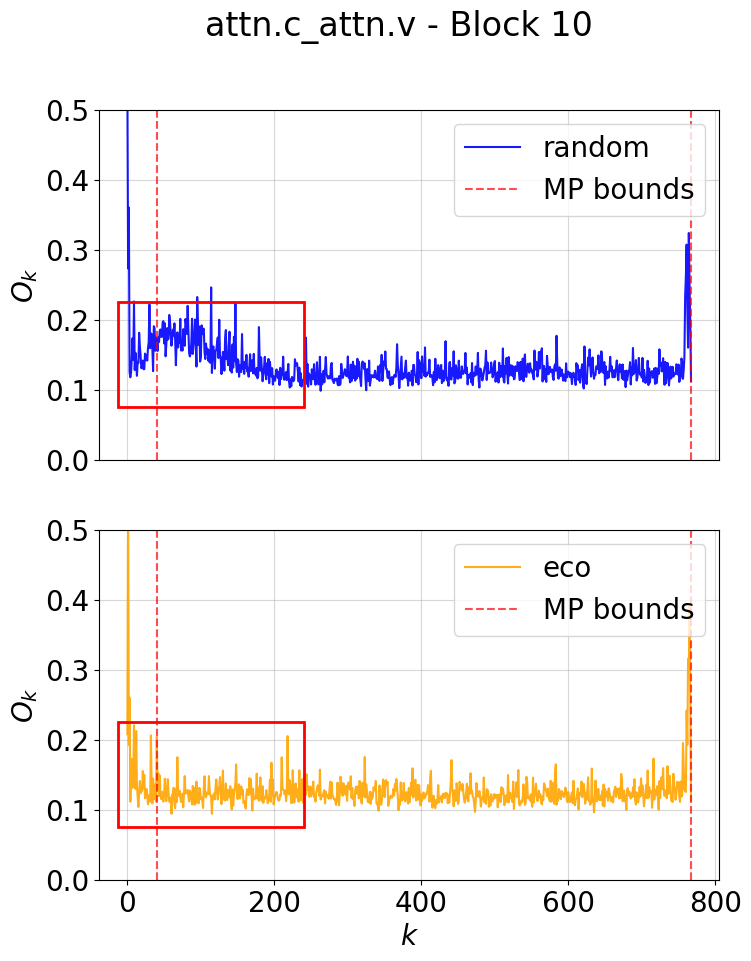

In [95]:
plot_overlap_comparison(layer, block, 768, 768, plot_dir, patch=True, patch_coords=[0.03, 0.15, 0.3, 0.3])

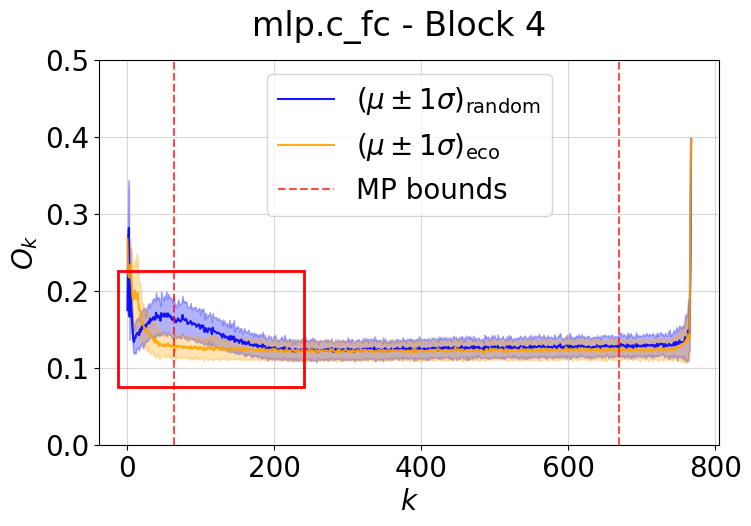

In [75]:
plot_overlap_comparison_bands(layer, block, 768, 4 * 768, final_data_dir, plot_dir, patch=True, patch_coords=[0.03, 0.15, 0.3, 0.3], close_up=False)

In [42]:
# plot_svals(svals.iloc[1:], 768, 4 * 768, svals.iloc[0], layer, block)
# plot_overlaps(svals.iloc[1:], overlaps_a, 768, 4 * 768, svals.iloc[0], layer, block, with_numbers=False)
# plot_svals_overlaps(svals.iloc[1:], overlaps_a, 768, 4*768, svals.iloc[0], layer, block, with_numbers=False)